# Standard Deviation Levels in Volatility



Import libaries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import dateutil
import requests


%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 5]

### Collect data

Pull in the relevant data from Bitmex

In [2]:
def collect_data(from_time: str, to_time: str, tf: str, contract: str = "ETHUSD") -> pd.DataFrame:

    url = "https://www.bitmex.com/api/v1/trade/bucketed"
    candles = {'timestamp': [], 'close': []}

    # Set inputs
    data = dict()
    data['symbol'] = contract
    data['partial'] = True  # returns a candle if it is not finished yet
    data['binSize'] = tf
    data['count'] = 500   # how many candles we can return (500 max)
    data['reverse'] = True

    data["startTime"] = datetime.datetime.strptime(from_time, '%Y-%m-%d %H:%M')
    data["endTime"] = datetime.datetime.strptime(to_time, '%Y-%m-%d %H:%M')

    BITMEX_TF_MINUTES = {"1m": 1, "5m": 5, "10m": 10, "15m": 15, "1h": 60, "1d": 1440}


    try:
        response = requests.get(url, params=data)
    except Exception as e:
        print(f"Connecton error while making GET request to {url}: {e}")
        return

    if response.status_code == 200:
        raw_candles = response.json()
    else:
        print(f"Error while making GET request to {url}: {response.status_code}")
        print(response.headers)
        return None
    
    if raw_candles is not None:
        for idx, c in enumerate(reversed(raw_candles)):
            ts = dateutil.parser.isoparse(c['timestamp'])
            ts = ts - datetime.timedelta(minutes=BITMEX_TF_MINUTES[tf])
            candles['timestamp'].append(ts)
            candles["close"].append(c["close"])


    return pd.DataFrame(candles)

Build the `DataFrame`

In [12]:
# from_time = "2022-07-30 00:00"
# to_time = "2022-08-01 15:00"
from_time = "2022-08-01 00:00"
to_time = "2022-08-01 16:00"
tf = "5m"
contract = "XBTUSD"

data = collect_data(from_time, to_time, tf, contract)
# data = data.set_index('timestamp')
data['std_dev'] = data['close'].rolling(window=30).std()

data = data.iloc[30:]
data

,timestamp,close,std_dev
30,2022-08-01 02:25:00+00:00,23419.5,53.168257
31,2022-08-01 02:30:00+00:00,23430.0,49.742567
32,2022-08-01 02:35:00+00:00,23406.5,45.352439
33,2022-08-01 02:40:00+00:00,23393.5,39.998707
34,2022-08-01 02:45:00+00:00,23381.5,34.048883
...,...,...,...
183,2022-08-01 15:10:00+00:00,23425.0,146.970112
184,2022-08-01 15:15:00+00:00,23315.0,146.004924
185,2022-08-01 15:20:00+00:00,23325.5,144.812464
186,2022-08-01 15:25:00+00:00,23359.0,143.923874


### Volatility Plot

<AxesSubplot:>

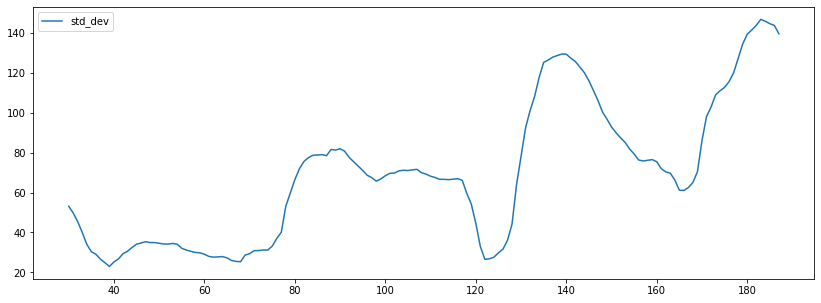

In [13]:
data.plot(y='std_dev')

### Close Price Plot

<AxesSubplot:>

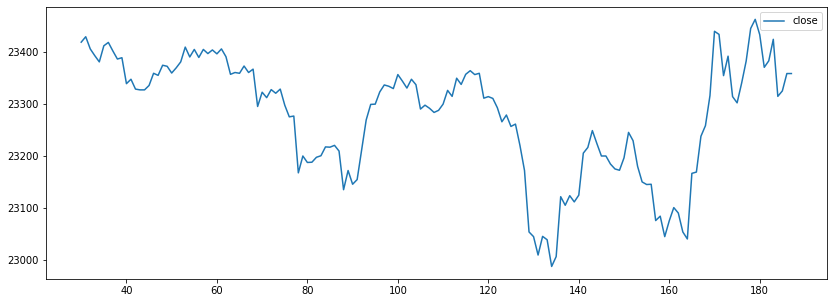

In [14]:
data.plot(y="close")